<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Tanh Activation mystery</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The following notebook is an attempt to making tanh converge, which I show here is not done by simply scaling the data to fit the second order derivative a certain way.
</p>

In [1]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils
using ForwardDiff
includet("Data.jl")
includet("NeuralNetwork.jl")
using Base.Threads

  Activating project at `~/~/.julia/environments/v1.11.1`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
┌ Warning: skipping callee Main.:(var"#RK4_step#6") (called by Main.RK4_step) due to AssertionError("isexpr(bodystmt, :call)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/h7PQC/src/signatures.jl:328


In [7]:
second_derivative(f, x) = ForwardDiff.derivative(x -> ForwardDiff.derivative(f, x), x)
x_vals = -5:0.01:5
sigmoid_second = [second_derivative(sigmoid, x) for x in x_vals]
tanh_second = [second_derivative(tanh, x) for x in x_vals]

1001-element Vector{Float64}:
  0.0003631334879210128
  0.0003704679119312004
  0.0003779504456768556
  0.0003855840789098888
  0.00039337186168692765
  0.0004013169055843909
  0.0004094223849358361
  0.0004176915380973487
  0.00042612766873563755
  0.0004347341471419374
  0.00044351441157637524
  0.00045247196963368945
  0.0004616103996385099
  ⋮
 -0.00045247196963368945
 -0.00044351441157637524
 -0.0004347341471419374
 -0.00042612766873563755
 -0.0004176915380973487
 -0.0004094223849358361
 -0.0004013169055843909
 -0.00039337186168692765
 -0.0003855840789098888
 -0.0003779504456768556
 -0.0003704679119312004
 -0.0003631334879210128

In [3]:
function sample_pend_scale(num_samples, min_energy=0.3, max_energy=1.3) #samples initial values
    data = zeros((2,num_samples))
    i=1
    m=1
    l=3
    g=3
    while i<num_samples+1
        # Random value for the Hamiltonian
        H = rand(Uniform(min_energy, max_energy))

        q = rand() * 2 * pi - pi  # Random q between -π and π

        p_squared = 2 * (H - m*g*l*(1 - cos(q)))*m*l^2
        if p_squared < 0
            continue
        end
        p = sqrt(p_squared)
        data[:,i] .= q,p
        i+=1
    end
    return data
end
function grads_ideal_pend_scale(y) #ODE for pendulum
    m=1
    g=3
    l=3
    q = y[1,:]
    p = y[2,:]
    dq_dt=p/(m*l^2)
    dp_dt = @. -g*m*l*sin(q)
    return permutedims(hcat(dq_dt, dp_dt))
end

grads_ideal_pend_scale (generic function with 1 method)

In [5]:
rng = Random.MersenneTwister(42)

fieldd = meshgrid(20, train=false)
spring_field = grads_ideal_pend(fieldd).*0.1

t, x_train,y_train = generate_data(grads_ideal_pend, 25, 30, 4*pi, sigma=0.01, sampler=sample_pend) |>f32
_, x_test, y_test = generate_data(grads_ideal_pend, 1, 30, 4*pi, sigma=0.01, sampler=sample_pend) |>f32

x_Train = reshape(x_train, 2, 30*25) #.|>f32
y_Train = reshape(y_train, 2, 30*25) #.|>f32

train_data = DataLoader((x_Train,y_Train),batchsize=30)

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (2×30 Matrix{Float32}, 2×30 Matrix{Float32},)

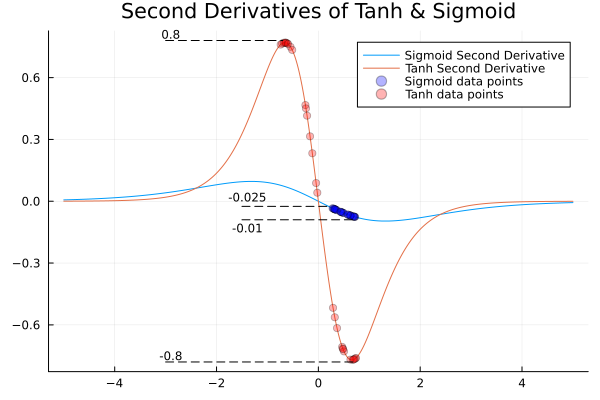

In [10]:

new_x_s = sigmoid.(x_test[1,:])
new_x_t = tanh.(x_test[1,:])
plot(x_test, new_x_s, title="Sigmoid activation")
sigmoid_second_p = [second_derivative(sigmoid, x) for x in new_x_s]
tanh_second_p = [second_derivative(tanh, x) for x in new_x_t]

plot(x_vals, sigmoid_second, label="Sigmoid Second Derivative")

plot!(x_vals, tanh_second, label="Tanh Second Derivative",title="Second Derivatives of Tanh & Sigmoid")
scatter!(new_x_s, sigmoid_second_p, color=:blue, label="Sigmoid data points",alpha=0.3)
scatter!(new_x_t, tanh_second_p,color=:red, label="Tanh data points",alpha=0.3)

plot!([-3,-0.7], [0.78,0.78],color=:black,label=nothing,ls=:dash)
plot!([-3,0.7], [-0.78,-0.78],color=:black,label=nothing,ls=:dash)

plot!([-1.5,0.19], [-0.025,-0.025],color=:black,label=nothing,ls=:dash)
plot!([-1.5,0.7], [-0.09,-0.09],color=:black,label=nothing,ls=:dash)

annotate!([(-1.4, -0.13, text("-0.01",8)),(-1.4, 0.02, text("-0.025",8)),(-2.9, -0.75, text("-0.8",8)),(-2.9, 0.81, text("0.8",8))])

<p style="font-family:Times New Roman; font-size:120%">
    The results here are very interesting. Tanh seem to polarize the gradients to +-0.8, and sigmoid seem to vanish the gradients. Maybe this could be a reason for non-convergence? We scale the data to be more favourable for tanh to test this theory
</p>

In [11]:
rng = Random.MersenneTwister(42)

fieldd = meshgrid(20, train=false)
spring_field = grads_ideal_pend(fieldd).*0.1

t, x_train,y_train = generate_data(grads_ideal_pend_scale, 25, 50, 5*pi, sigma=0.01, sampler=sample_pend_scale,min_e=0.3, max_e=1.3) |>f32
_, x_test, y_test = generate_data(grads_ideal_pend_scale, 1, 50, 5*pi, sigma=0.01, sampler=sample_pend_scale,min_e=0.3, max_e=1.3) |>f32

x_Train = reshape(x_train, 2, 50*25) #.|>f32
y_Train = reshape(y_train, 2, 50*25) #.|>f32

train_data = DataLoader((x_Train,y_Train),batchsize=50)


25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=50)
  with first element:
  (2×50 Matrix{Float32}, 2×50 Matrix{Float32},)

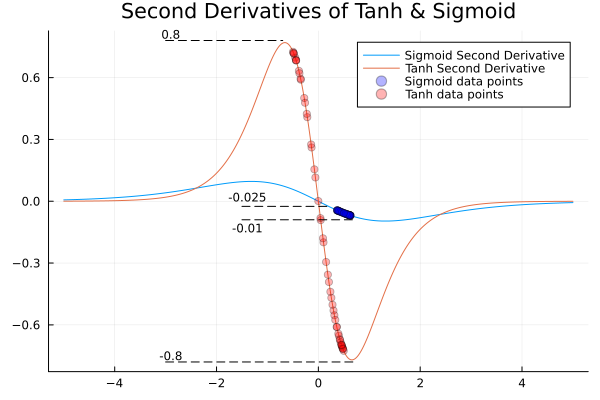

In [12]:
x_temp = range(-1.5, 1.5, 15)
new_x_s = sigmoid.(x_test[1,:])
new_x_t = tanh.(x_test[1,:])
plot(x_temp, new_x_s, title="Sigmoid activation")
sigmoid_second_p = [second_derivative(sigmoid, x) for x in new_x_s]
tanh_second_p = [second_derivative(tanh, x) for x in new_x_t]

plot(x_vals, sigmoid_second, label="Sigmoid Second Derivative")

plot!(x_vals, tanh_second, label="Tanh Second Derivative",title="Second Derivatives of Tanh & Sigmoid")
scatter!(new_x_s, sigmoid_second_p, color=:blue, label="Sigmoid data points",alpha=0.3)
scatter!(new_x_t, tanh_second_p,color=:red, label="Tanh data points",alpha=0.3)

plot!([-3,-0.7], [0.78,0.78],color=:black,label=nothing,ls=:dash)
plot!([-3,0.7], [-0.78,-0.78],color=:black,label=nothing,ls=:dash)

plot!([-1.5,0.19], [-0.025,-0.025],color=:black,label=nothing,ls=:dash)
plot!([-1.5,0.7], [-0.09,-0.09],color=:black,label=nothing,ls=:dash)

annotate!([(-1.4, -0.13, text("-0.01",8)),(-1.4, 0.02, text("-0.025",8)),(-2.9, -0.75, text("-0.8",8)),(-2.9, 0.81, text("0.8",8))])

<p style="font-family:Times New Roman; font-size:120%">
    The data now fits the second order derivative of tanh much more continously, and we should expect different results if this is indeed why tanh has performed so poorly.
</p>

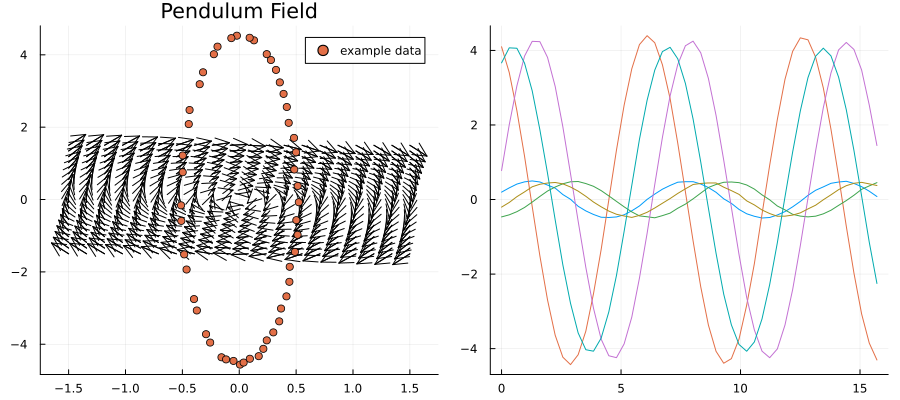

In [13]:
quiver(fieldd[1, :],fieldd[2, :],quiver=(spring_field[1, :], spring_field[2, :]), layout=(1,2),size=(900,400), title="Pendulum Field", label="train data",c=:black)
for i in 2:4
    plot!(t, x_train[1,:,i], subplot=2,legend=false)
    plot!(t, x_train[2,:,i], subplot=2,legend=false)
end
scatter!(x_train[1,:,1], x_train[2,:,1], label="example data",subplot=1)

In [14]:
gain_str = ["0.1", "0.5", "3/5","1.0", "√2", "2.0", "5"]

7-element Vector{String}:
 "0.1"
 "0.5"
 "3/5"
 "1.0"
 "√2"
 "2.0"
 "5"

<h2 style="font-family:Times New Roman; font-size:200%">Conducting analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    We will now train the HNN's with tanh with various gains=0.01,0.1,0.5,1,s^0.5,2 and 5. This is done for Kaiming, Glorot and Orthogonal weight initilization. The example presented here consists of 64 neurons, with two hidden layers. If the reason for tanh's poor performance is the second order derivatives polarizing the data, then we should expect tanh to converge at least once now.
</p>

In [15]:
act = tanh
gains = [ .1, .5, 1, 2^0.5,5/3, 2, 5]

MSE_vals = zeros(4, length(gains))


Threads.@threads for g_idx in 1:length(gains)
    g_val=gains[g_idx]
    println("Doing: Gain $(g_val)")
    
    _, LuxH_k = models(2, 64, act, Kaiming(g_val),2)
    _, LuxH_g = models(2, 64, act, Glorot(g_val),2)
    _, LuxH_o = models(2, 64, act, Orthogonal(g_val),2)

    #println(" -----  Training Glorot  ----- ")
    pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1000)
    lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
    MSE_vals[3,g_idx] = lossg

    #println(" -----  Training Kaiming  ----- ")
    pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000)
    lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
    MSE_vals[2,g_idx] = lossk

    #println(" -----  Training Orthogonal  ----- ")
    pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1000)
    losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
    MSE_vals[4,g_idx] = losso

end

Doing: Gain 0.1
Doing: Gain 5.0
Doing: Gain 1.0
Doing: Gain 1.4142135623730951
Doing: Gain 0.5
Doing: Gain 2.0
Doing: Gain 1.6666666666666667
Epoch=200 :loss = 0.076209456
Epoch=200 :loss = 0.071363404
Epoch=200 :loss = 0.07665914
Epoch=200 :loss = 0.06971731
Epoch=200 :loss = 0.47068417
Epoch=200 :loss = 0.077418104
Epoch=200 :loss = 0.07883266
Epoch=400 :loss = 0.07143192
Epoch=400 :loss = 0.06991247
Epoch=400 :loss = 0.075024836
Epoch=400 :loss = 0.07476966
Epoch=400 :loss = 0.18691008
Epoch=400 :loss = 0.07441685
Epoch=400 :loss = 0.07314808
Epoch=600 :loss = 0.07153086
Epoch=600 :loss = 0.07235199
Epoch=600 :loss = 0.069874056
Epoch=600 :loss = 0.17933588
Epoch=600 :loss = 0.07294114
Epoch=600 :loss = 0.07189736
Epoch=600 :loss = 0.078316025
Epoch=800 :loss = 0.07147559
Epoch=800 :loss = 0.0761857
Epoch=800 :loss = 0.06983626
Epoch=800 :loss = 0.074403174
Epoch=800 :loss = 0.17450407
Epoch=800 :loss = 0.07102162
Epoch=800 :loss = 0.07064116
Epoch=1000 :loss = 0.07134541
Epoch=1000

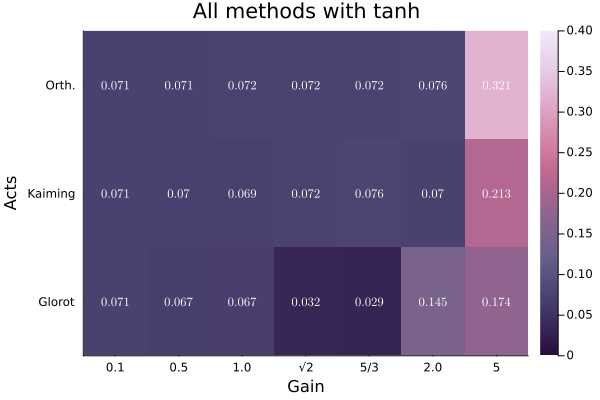

In [22]:
methods_str = ["Glorot", "Kaiming","Orth."]
gain_str = ["0.1", "0.5", "1.0", "√2", "5/3","2.0", "5"]
hg = heatmap(MSE_vals, cmap=:acton,clim=(0, 0.4),title="All methods with tanh", yticks=(1:3, methods_str), xticks=(1:length(gains), gain_str), ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_vals[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:3 for j in 1:length(gains)])
hg

In [233]:
act = tanh
gains = [ .1, .5, 3/5, 1, 2^0.5, 2, 5]

MSE_vals = zeros(4, length(gains))


Threads.@threads for g_idx in 1:length(gains)
    g_val=gains[g_idx]
    println("Doing: Gain $(g_val)")
    _, LuxH_k = models(2, 200, act, Kaiming(g_val),2)
    _, LuxH_g = models(2, 200, act, Glorot(g_val),2)
    _, LuxH_o = models(2, 200, act, Orthogonal(g_val),2)
    _, LuxH_s = models(2, 200, act, SekkelstenU(g_val),2)

    pHNN_s, sHNN_s = train_model(LuxH_s, lossHNN, train_data, x_test, y_test;epochs=2000)
    losss = lossHNN(LuxH_s, x_test,pHNN_s, sHNN_s ,y_test)
    MSE_vals[1,g_idx] = losss

    #println(" -----  Training Kaiming  ----- ")
    pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=2000)
    lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
    MSE_vals[2,g_idx] = lossk

    #println(" -----  Training Glorot  ----- ")
    pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=2000)
    lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
    MSE_vals[3,g_idx] = lossg

    #println(" -----  Training Orthogonal  ----- ")
    pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=2000)
    losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
    MSE_vals[4,g_idx] = losso

end

Doing: Gain 0.1
Doing: Gain 2.0
Doing: Gain 5.0
Doing: Gain 1.4142135623730951
Doing: Gain 0.5
Doing: Gain 1.0
Doing: Gain 0.6


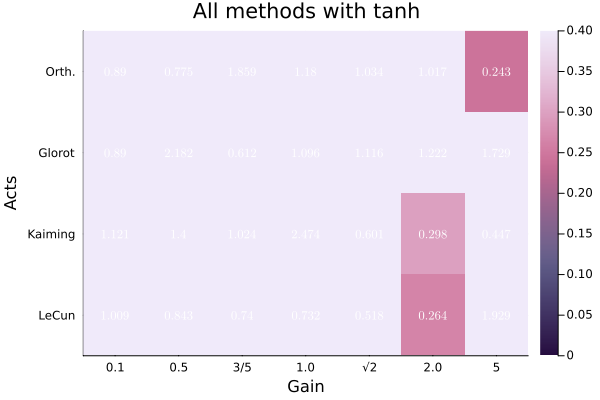

In [234]:
methods_str = ["LeCun", "Kaiming", "Glorot", "Orth."]
hg = heatmap(MSE_vals, cmap=:acton,clim=(0, 0.4),title="All methods with tanh", yticks=(1:4, methods_str), xticks=(1:length(gains), gain_str), ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_vals[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:4 for j in 1:length(gains)])
hg

<p style="font-family:Times New Roman; font-size:120%">
    The loss went down to 0.3 for 64 hidden units, could this imply that tanh converged? We try to see what it looks like before concluding anything.
</p>

In [23]:
_, LuxH = models(2, 64, tanh, Glorot(5/3),2)

pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=2000)
losss = lossHNN(LuxH, x_test,pHNN, sHNN ,y_test)

Epoch=200 :loss = 0.077418104
Epoch=400 :loss = 0.07441685
Epoch=600 :loss = 0.07189736
Epoch=800 :loss = 0.07102162
Epoch=1000 :loss = 0.07576725
Epoch=1200 :loss = 0.069104545
Epoch=1400 :loss = 0.06839517
Epoch=1600 :loss = 0.06783313
Epoch=1800 :loss = 0.06756276
Epoch=2000 :loss = 0.06745293


0.06745293f0

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64, Base.Slice{Base.OneTo{Int64}}}, false}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/wiiF1/src/impl/matmul.jl:145


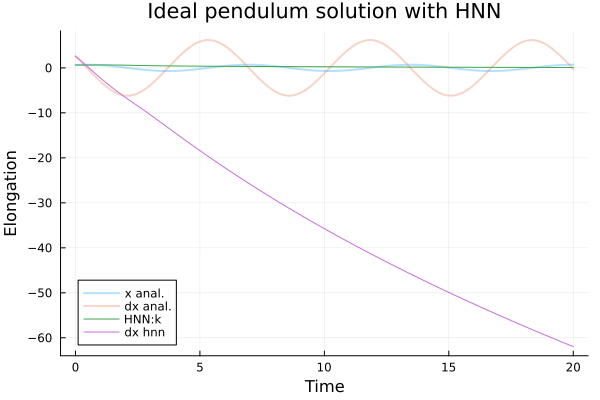

In [24]:
hnn = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)

t, esth, _ = generate_data(simHNN, 1, 400, 20., sampler=sample_pend_scale, model = hnn)
t, analk, _ = generate_data(grads_ideal_pend_scale, 1, 400, 20., inits= esth[:,1])

plot(t, analk[1,:], title = "Ideal pendulum solution with HNN",
    xaxis = "Time", yaxis = "Elongation", label = "x anal.", alpha=.3,linewidth=2)
plot!(t, analk[2,:], xaxis = "Time", yaxis = "Elongation", label = "dx anal.",alpha=.3,linewidth=2)
plot!(t, esth[1,:], label="HNN:k")
plot!(t, esth[2,:], label="dx hnn")

<p style="font-family:Times New Roman; font-size:120%">
    Unfortunately, this can not be considered convergence, not even close. No tanh method has converged yet, and scaling the data therefore does not work, at all! Several different combinations has been attempted, and all results are similar to this. The problem does, interestingly enough, not lie in the second order derivative of tanh. 
</p>